i want you to integrate these 2 codes so that they run together. here is the first one that creates pdf graphs (paste.txt). then i want to use the pdf value obtained within this to produce a trad off curve utilising paste-2.txt 
#### NOTE
paste.txt is Neil's original code created from his Perlexity AI string 
paste-2.txt is my original code created from Perplexity AI string 

### ANSWER 

To integrate these two codes and create a combined simulation that produces both PDF graphs and a trade-off curve, we'll need to modify and merge the code. Here's an integrated version that combines both functionalities:

In [1]:
import simpy
import random
import math
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np

# Simulation parameters
WARM_UP_DAYS = 365 * 3  # 3 years warm-up
SIMULATION_DAYS = 365 * 8  # Total simulation length (8 years)
RUN_LENGTH_DAYS = SIMULATION_DAYS - WARM_UP_DAYS  # Exclude warm-up period

# Initialize simulation environment
env = simpy.Environment()

# Create units with effectively unlimited capacity
ACUTE_STROKE_UNIT = simpy.Resource(env, capacity=1000000)
REHAB_UNIT = simpy.Resource(env, capacity=1000000)

# Updated lognormal distribution parameters for ASU length of stay
LOS_PARAMS = {
    'Stroke-rehab': {'mu': 1.574, 'sigma': 0.924},
    'Stroke-ESD': {'mu': 1.158, 'sigma': 0.858},
    'Stroke-other': {'mu': 1.479, 'sigma': 0.966},
    'TIA': {'mu': 0.104, 'sigma': 0.984},
    'Complex Neurological': {'mu': 0.916, 'sigma': 0.970},
    'Other': {'mu': 0.807, 'sigma': 1.027}
}

# Mean admission rates (days between arrivals) to the ASU
ADMISSION_RATES_ASU = {
    'Stroke': 1.2,
    'TIA': 9.3,
    'Complex Neurological': 3.6,
    'Other': 3.2
}

# Mean admission rates to the RU
ADMISSION_RATES_RU = {
    'Stroke': 21.8,
    'Complex Neurological': 31.7,
    'Other': 28.6
}

# Discharge probabilities from ASU
PATIENT_DISCHARGE_PROB = {
    'Stroke': {'RU': 0.24, 'ESD': 0.13, 'Other': 0.63},
    'TIA': {'RU': 0.01, 'ESD': 0.01, 'Other': 0.98},
    'Complex Neurological': {'RU': 0.11, 'ESD': 0.05, 'Other': 0.84},
    'Other': {'RU': 0.05, 'ESD': 0.10, 'Other': 0.85}
}

# RU discharge probabilities
RU_DISCHARGE_PROB = {
    'Stroke': {'ESD': 0.40, 'Other': 0.60},
    'TIA': {'ESD': 0.00, 'Other': 1.00},
    'Complex Neurological': {'ESD': 0.09, 'Other': 0.91},
    'Other': {'ESD': 0.12, 'Other': 0.88}
}

# Updated lognormal distribution parameters for RU length of stay
RU_LOS_PARAMS = {
    'Stroke-Other': {'mu': 3.021, 'sigma': 0.807},
    'Stroke-ESD': {'mu': 3.182, 'sigma': 0.677},
    'Complex Neurological': {'mu': 2.957, 'sigma': 0.850},
    'Other': {'mu': 2.494, 'sigma': 0.755},
    'TIA': {'mu': 2.455, 'sigma': 0.973}
}

# Track occupancy data
occupancy_data = {
    'asu_daily': [],
    'ru_daily': []
}

def get_los(patient_type, unit='ASU'):
    """Generate lognormal length of stay based on patient type and unit"""
    if unit == 'ASU':
        params = LOS_PARAMS[patient_type]
    else:  # unit == 'RU'
        params = RU_LOS_PARAMS[patient_type]
    return max(0.1, lognorm.rvs(s=params['sigma'], scale=math.exp(params['mu'])))

def patient_process_asu(env, patient_type, asu, ru):
    """Simulates individual patient flow through the ASU"""
    if patient_type == 'Stroke':
        subtype = random.choices(['RU', 'ESD', 'Other'], weights=[0.24, 0.13, 0.63], k=1)[0]
        los_type = f'Stroke-{subtype.lower()}' if subtype != 'RU' else 'Stroke-rehab'
    else:
        los_type = patient_type

    with asu.request() as req:
        yield req
        los = get_los(los_type, 'ASU')
        yield env.timeout(los)

    if patient_type == 'Stroke':
        destination = subtype
    else:
        destination = random.choices(list(PATIENT_DISCHARGE_PROB[patient_type].keys()),
                                     weights=list(PATIENT_DISCHARGE_PROB[patient_type].values()), k=1)[0]

    if destination == 'RU':
        env.process(patient_process_ru(env, patient_type, asu, ru))

def patient_process_ru(env, patient_type, asu, ru, origin="ASU"):
    """Simulates individual patient flow through the RU"""
    with ru.request() as req:
        yield req
        if patient_type == 'Stroke':
            destination = random.choices(['ESD', 'Other'], weights=[0.40, 0.60], k=1)[0]
            los_type = f'Stroke-{destination}'
        else:
            los_type = patient_type
        los = get_los(los_type, 'RU')
        yield env.timeout(los)

def patient_generator_asu(env, patient_type, asu, ru):
    """Generates patients for the ASU"""
    while True:
        inter_arrival_time = random.expovariate(1 / ADMISSION_RATES_ASU[patient_type])
        yield env.timeout(inter_arrival_time)
        env.process(patient_process_asu(env, patient_type, asu, ru))

def patient_generator_ru(env, patient_type, asu, ru):
    """Generates patients directly for the RU"""
    if patient_type in ADMISSION_RATES_RU:
        while True:
            inter_arrival_time = random.expovariate(1 / ADMISSION_RATES_RU[patient_type])
            yield env.timeout(inter_arrival_time)
            env.process(patient_process_ru(env, patient_type, asu, ru, origin="Direct"))

def occupancy_monitor(env, asu, ru):
    """Tracks daily occupancy levels"""
    while True:
        occupancy_data['asu_daily'].append(len(asu.users))
        occupancy_data['ru_daily'].append(len(ru.users))
        yield env.timeout(1)

# Setup monitoring and patient generators
env.process(occupancy_monitor(env, ACUTE_STROKE_UNIT, REHAB_UNIT))

for pt in ADMISSION_RATES_ASU:
    env.process(patient_generator_asu(env, pt, ACUTE_STROKE_UNIT, REHAB_UNIT))

for pt in ADMISSION_RATES_RU:
    env.process(patient_generator_ru(env, pt, ACUTE_STROKE_UNIT, REHAB_UNIT))

# Execute simulation
env.run(until=SIMULATION_DAYS)

# Remove warmup period
occupancy_data['asu_daily'] = occupancy_data['asu_daily'][WARM_UP_DAYS:]
occupancy_data['ru_daily'] = occupancy_data['ru_daily'][WARM_UP_DAYS:]

# Calculate statistics
print(f"ASU Average Occupancy (5-year post-warmup): {sum(occupancy_data['asu_daily'])/len(occupancy_data['asu_daily']):.1f}")
print(f"RU Average Occupancy (5-year post-warmup): {sum(occupancy_data['ru_daily'])/len(occupancy_data['ru_daily']):.1f}")

# Generate PDF bar chart for ASU occupancy
def generate_pdf_chart(occupancy_data, unit_name, min_occupancy, max_occupancy):
    occupancy_counts, _ = np.histogram(occupancy_data, bins=np.arange(min_occupancy, max_occupancy + 1))
    occupancy_probabilities = occupancy_counts / len(occupancy_data)
    x_values = np.arange(min_occupancy, max_occupancy)

    plt.figure(figsize=(12, 6))
    plt.bar(x_values, occupancy_probabilities * 100, color='black', width=0.7)
    plt.xlabel(f'No. patients in {unit_name.lower()} unit')
    plt.ylabel('% observations')
    plt.title(f'{unit_name} Occupancy Probability Density Function')
    plt.xlim(min_occupancy - 0.5, max_occupancy - 0.5)
    plt.ylim(0, max(occupancy_probabilities * 100) * 1.1)
    plt.xticks(np.arange(min_occupancy, max_occupancy, 1))
    plt.yticks(np.arange(0, int(max(occupancy_probabilities * 100)) + 2, 2))
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    plt.show()

    return occupancy_probabilities

# Generate PDF charts
asu_pdf = generate_pdf_chart(occupancy_data['asu_daily'], 'ASU', 1, 30)
ru_pdf = generate_pdf_chart(occupancy_data['ru_daily'], 'Rehab', 1, 30)

# Calculate CDF and delay probabilities for ASU
asu_cdf = np.cumsum(asu_pdf)
bed_range = np.arange(0, 29)
delay_probs = [1.0 if n == 0 else (1 - asu_cdf[n-1] if n <= len(asu_cdf) else 0.0) for n in bed_range]

# Create trade-off curve
plt.figure(figsize=(10, 6))
plt.step(bed_range, delay_probs, where="post", linewidth=2, color="black")
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10)
plt.xticks(np.arange(0, 29, 2), fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.ylabel("Probability of delay", fontsize=12)
plt.xlabel("No. of acute beds available", fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Print key statistics
print("\nKey delay probabilities:")
for n in [10, 15, 20, 25, 28]:
    print(f"{n} beds: {delay_probs[n]:.2%}")


KeyError: 'Stroke-esd'

NameError: name 'subtype' is not defined

ASU Average Occupancy (5-year post-warmup): 8.0
RU Average Occupancy (5-year post-warmup): 9.4


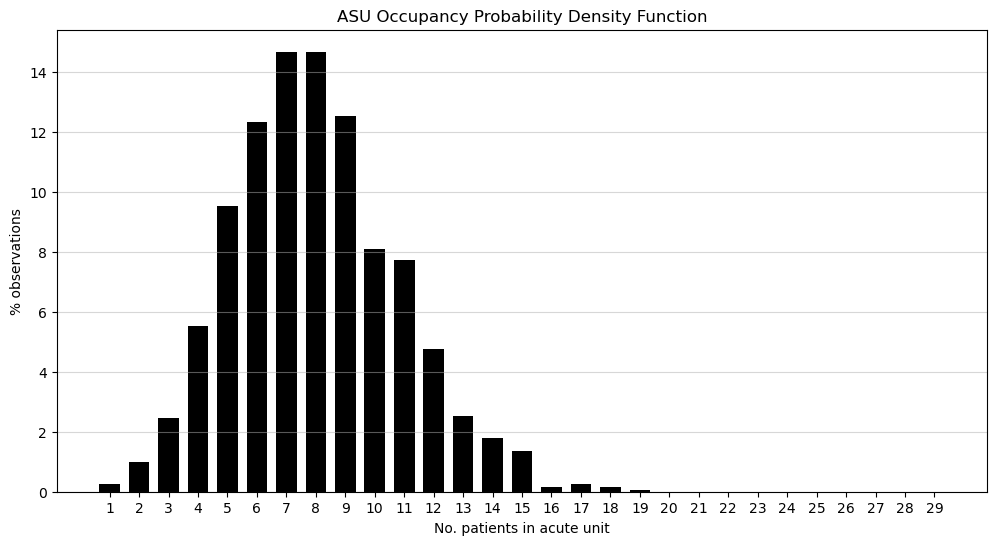

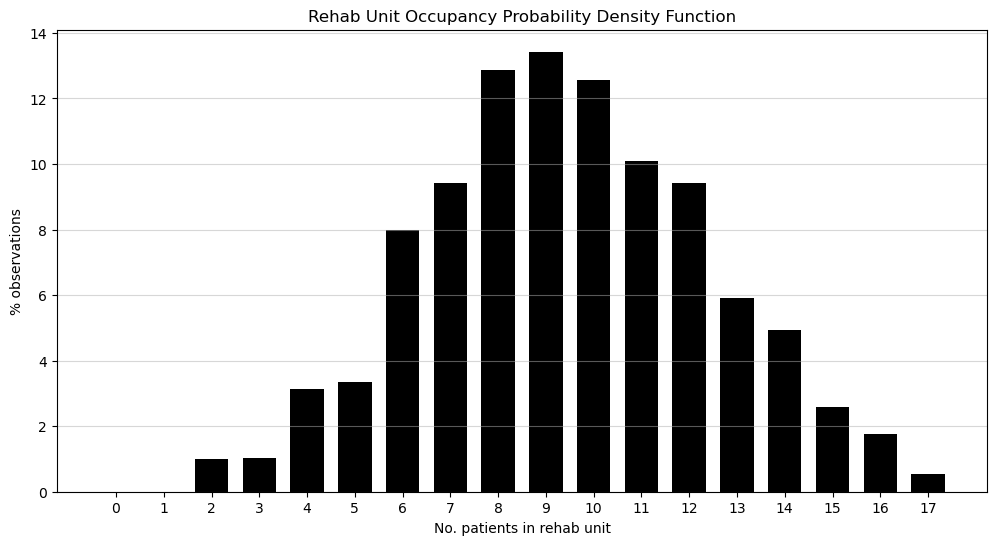

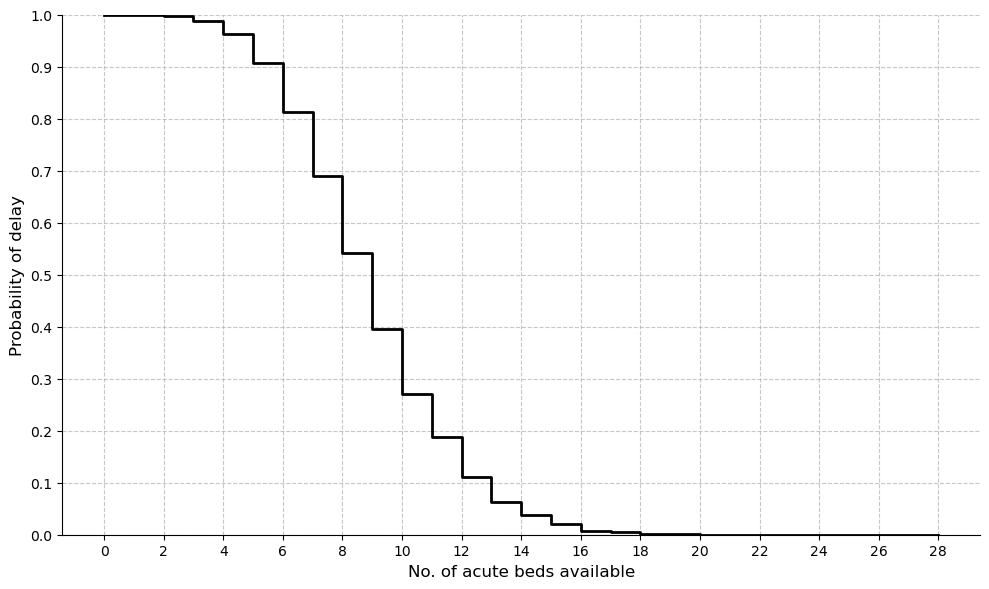

Simulation Results (1825 days after warm-up):
Maximum observed ASU occupancy: 19
Average ASU occupancy: 8.00 ± 2.81

Key delay probabilities:
10 beds: 26.96%
15 beds: 2.03%
20 beds: 0.00%
25 beds: 0.00%
28 beds: 0.00%


In [3]:
import simpy
import random
import math
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np

# Initialize simulation environment
env = simpy.Environment()

# Simulation parameters
WARM_UP_DAYS = 365 * 3  # 3 years warm-up
SIMULATION_DAYS = 365 * 8  # Total simulation length (8 years)
RUN_LENGTH_DAYS = SIMULATION_DAYS - WARM_UP_DAYS  # Exclude warm-up period

# Create units with effectively unlimited capacity
ACUTE_STROKE_UNIT = simpy.Resource(env, capacity=1000000)
REHAB_UNIT = simpy.Resource(env, capacity=1000000)

# Updated lognormal distribution parameters for ASU length of stay
LOS_PARAMS = {
    'Stroke-rehab': {'mu': 1.574, 'sigma': 0.924},
    'Stroke-ESD': {'mu': 1.158, 'sigma': 0.858},
    'Stroke-other': {'mu': 1.479, 'sigma': 0.966},
    'TIA': {'mu': 0.104, 'sigma': 0.984},
    'Complex Neurological': {'mu': 0.916, 'sigma': 0.970},
    'Other': {'mu': 0.807, 'sigma': 1.027}
}

# Mean admission rates (days between arrivals) to the ASU
ADMISSION_RATES_ASU = {
    'Stroke': 1.2,
    'TIA': 9.3,
    'Complex Neurological': 3.6,
    'Other': 3.2
}

# Mean admission rates to the RU
ADMISSION_RATES_RU = {
    'Stroke': 21.8,
    'Complex Neurological': 31.7,
    'Other': 28.6
}

# Discharge probabilities from ASU
PATIENT_DISCHARGE_PROB = {
    'Stroke': {
        'RU': 0.24,  # Stroke-rehab
        'ESD': 0.13,  # Stroke-ESD
        'Other': 0.63  # Stroke-other
    },
    'TIA': {
        'RU': 0.01,
        'ESD': 0.01,
        'Other': 0.98
    },
    'Complex Neurological': {
        'RU': 0.11,
        'ESD': 0.05,
        'Other': 0.84
    },
    'Other': {
        'RU': 0.05,
        'ESD': 0.10,
        'Other': 0.85
    }
}

# RU discharge probabilities
RU_DISCHARGE_PROB = {
    'Stroke': {'ESD': 0.40, 'Other': 0.60},
    'TIA': {'ESD': 0.00, 'Other': 1.00},
    'Complex Neurological': {'ESD': 0.09, 'Other': 0.91},
    'Other': {'ESD': 0.12, 'Other': 0.88}
}

# Updated lognormal distribution parameters for RU length of stay
RU_LOS_PARAMS = {
    'Stroke-Other': {'mu': 3.021, 'sigma': 0.807},
    'Stroke-ESD': {'mu': 3.182, 'sigma': 0.677},
    'Complex Neurological': {'mu': 2.957, 'sigma': 0.850},
    'Other': {'mu': 2.494, 'sigma': 0.755},
    'TIA': {'mu': 2.455, 'sigma': 0.973}
}

# Track occupancy data
occupancy_data = {
    'asu_daily': [],
    'ru_daily': []
}

def get_los(patient_type, unit='ASU'):
    """Generate lognormal length of stay based on patient type and unit"""
    if unit == 'ASU':
        params = LOS_PARAMS[patient_type]
    else:  # unit == 'RU'
        params = RU_LOS_PARAMS[patient_type]
    return max(0.1, lognorm.rvs(s=params['sigma'], scale=math.exp(params['mu'])))

def patient_process_asu(env, patient_type, asu, ru):
    """Simulates individual patient flow through the ASU"""
    # Determine subtype for Stroke patients
    if patient_type == 'Stroke':
        subtype = random.choices(
            ['RU', 'ESD', 'Other'],  # Subtype options
            weights=[0.24, 0.13, 0.63],  # Stroke subtype probabilities
            k=1
        )[0]
        # Map subtype to correct LOS_PARAMS key
        if subtype == 'RU':
            los_type = 'Stroke-rehab'
        elif subtype == 'ESD':
            los_type = 'Stroke-ESD'
        else:
            los_type = 'Stroke-other'
    else:
        los_type = patient_type

    # ASU Admission
    with asu.request() as req:
        yield req
        los = get_los(los_type, 'ASU')
        yield env.timeout(los)

    # Determine post-ASU destination
    if patient_type == 'Stroke':
        destination = subtype
    else:
        destinations = list(PATIENT_DISCHARGE_PROB[patient_type].keys())
        weights = list(PATIENT_DISCHARGE_PROB[patient_type].values())
        destination = random.choices(destinations, weights=weights, k=1)[0]

    # Rehab Unit admission if required
    if destination == 'RU':
        env.process(patient_process_ru(env, patient_type, asu, ru))  # Send to RU
    # Otherwise, exit the system (no more tracking)

def patient_process_ru(env, patient_type, asu, ru, origin="ASU"):
    """Simulates individual patient flow through the RU"""
    with ru.request() as req:
        yield req

        # Determine RU discharge destination
        if patient_type == 'Stroke':
            destination = random.choices(['ESD', 'Other'], weights=[0.40, 0.60], k=1)[0]
            los_type = f'Stroke-{destination}'  # Use subtype for Stroke patients
        else:
            los_type = patient_type  # Use generic patient type for others

        los = get_los(los_type, 'RU')
        yield env.timeout(los)

    # Determine RU discharge destination
    if patient_type == 'Stroke':
        destination = random.choices(['ESD', 'Other'], weights=[0.40, 0.60], k=1)[0]
    elif patient_type == 'TIA':
        destination = 'Other'
    elif patient_type == 'Complex Neurological':
        destination = random.choices(['ESD', 'Other'], weights=[0.09, 0.91], k=1)[0]
    else:
        destination = random.choices(['ESD', 'Other'], weights=[0.12, 0.88], k=1)[0]

    # No further tracking after RU discharge

def patient_generator_asu(env, patient_type, asu, ru):
    """Generates patients for the ASU"""
    while True:
        # Exponential distribution for inter-arrival times
        inter_arrival_time = random.expovariate(1 / ADMISSION_RATES_ASU[patient_type])
        yield env.timeout(inter_arrival_time)
        env.process(patient_process_asu(env, patient_type, asu, ru))

def patient_generator_ru(env, patient_type, asu, ru):
    """Generates patients directly for the RU"""
    if patient_type in ADMISSION_RATES_RU:
        while True:
            inter_arrival_time = random.expovariate(1 / ADMISSION_RATES_RU[patient_type])
            yield env.timeout(inter_arrival_time)
            env.process(patient_process_ru(env, patient_type, asu, ru, origin="Direct"))

def occupancy_monitor(env, asu, ru):
    """Tracks daily occupancy levels"""
    while True:
        occupancy_data['asu_daily'].append(len(asu.users))
        occupancy_data['ru_daily'].append(len(ru.users))
        yield env.timeout(1)

# Setup monitoring and patient generators
env.process(occupancy_monitor(env, ACUTE_STROKE_UNIT, REHAB_UNIT))

# Generators for ASU admissions
for pt in ADMISSION_RATES_ASU:
    env.process(patient_generator_asu(env, pt, ACUTE_STROKE_UNIT, REHAB_UNIT))

# Generators for direct RU admissions
for pt in ADMISSION_RATES_RU:
    env.process(patient_generator_ru(env, pt, ACUTE_STROKE_UNIT, REHAB_UNIT))

# Execute simulation
env.run(until=SIMULATION_DAYS)  # 8 years total (3 warmup + 5 data collection)

# Remove warmup period (first 3 years/1095 days)
occupancy_data['asu_daily'] = occupancy_data['asu_daily'][WARM_UP_DAYS:]
occupancy_data['ru_daily'] = occupancy_data['ru_daily'][WARM_UP_DAYS:]

# Calculate statistics
print(f"ASU Average Occupancy (5-year post-warmup): {sum(occupancy_data['asu_daily'])/len(occupancy_data['asu_daily']):.1f}")
print(f"RU Average Occupancy (5-year post-warmup): {sum(occupancy_data['ru_daily'])/len(occupancy_data['ru_daily']):.1f}")

# Generate PDF bar chart for ASU occupancy
asu_occupancy = occupancy_data['asu_daily']
min_occupancy_asu = 1
max_occupancy_asu = 30

occupancy_counts_asu, _ = np.histogram(asu_occupancy, bins=np.arange(min_occupancy_asu, max_occupancy_asu + 1))
occupancy_probabilities_asu = occupancy_counts_asu / len(asu_occupancy)

# x-axis values for the chart
x_values_asu = np.arange(min_occupancy_asu, max_occupancy_asu)

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x_values_asu, occupancy_probabilities_asu * 100, color='black', width=0.7)

# Customize the chart
plt.xlabel('No. patients in acute unit')
plt.ylabel('% observations')
plt.title('ASU Occupancy Probability Density Function')

#plt.xlim(min_occupancy_asu - 0.5, max_occupancy_asu - 0.5)
#plt.ylim(0, max(occupancy_probabilities_asu * 100) * 1.1)

plt.xticks(np.arange(min_occupancy_asu, max_occupancy_asu, 1))  # Ensure all x-axis labels are integers
#plt.yticks(np.arange(0, int(max(occupancy_probabilities_asu * 100)) + 2, 2))

plt.grid(axis='y', linestyle='-', alpha=0.5)

# Display the plot
plt.show()

# Generate PDF bar chart for RU occupancy
ru_occupancy = occupancy_data['ru_daily']
min_occupancy_ru = 0
max_occupancy_ru = max(ru_occupancy) + 1

occupancy_counts_ru = np.bincount(ru_occupancy, minlength=max_occupancy_ru)
occupancy_probabilities_ru = occupancy_counts_ru / len(ru_occupancy)

# x-axis values for the chart
x_values_ru = np.arange(min_occupancy_ru, max_occupancy_ru)

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x_values_ru, occupancy_probabilities_ru * 100, color='black', width=0.7)

# Customize the chart
plt.xlabel('No. patients in rehab unit')
plt.ylabel('% observations')
plt.title('Rehab Unit Occupancy Probability Density Function')

#plt.xlim(min_occupancy_ru - 0.5, max_occupancy_ru - 0.5)
#plt.ylim(0, max(occupancy_probabilities_ru * 100) * 1.1)

plt.xticks(np.arange(min_occupancy_ru, max_occupancy_ru, 1))  # Ensure all x-axis labels are integers
#plt.yticks(np.arange(0, int(max(occupancy_probabilities_ru * 100)) + 2, 2))

plt.grid(axis='y', linestyle='-', alpha=0.5)

# Display the plot
plt.show()

# Calculate CDF and delay probabilities for ASU
max_occ_asu = max(asu_occupancy)
counts_asu = np.bincount(asu_occupancy, minlength=max_occ_asu + 1)
pdf_asu = counts_asu / len(asu_occupancy)
cdf_asu = np.cumsum(pdf_asu)

# Calculate delay probabilities using P(N≥n) = 1 - P(N<n)
bed_range = np.arange(0, 29)  # Beds from 0 to 28
delay_probs = []

for n in bed_range:
    if n == 0:
        delay_probs.append(1.0)  # Certain delay with no beds
    else:
        if n <= len(cdf_asu):
            delay_probs.append(1 - cdf_asu[n-1])
        else:
            delay_probs.append(0.0)

# Create plot matching reference image style
plt.figure(figsize=(10, 6))

# Main curve - using step function for exact match
plt.step(bed_range, delay_probs, where="post", linewidth=2, color="black")

# Formatting to match reference
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10)
plt.xticks(np.arange(0, 29, 2), fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.ylabel("Probability of delay", fontsize=12)
plt.xlabel("No. of acute beds available", fontsize=12)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print key statistics
print(f"Simulation Results ({RUN_LENGTH_DAYS} days after warm-up):")
print(f"Maximum observed ASU occupancy: {max(asu_occupancy)}")
print(f"Average ASU occupancy: {np.mean(asu_occupancy):.2f} ± {np.std(asu_occupancy):.2f}")
print("\nKey delay probabilities:")
for n in [10, 15, 20, 25, 28]:
    print(f"{n} beds: {delay_probs[n]:.2%}")
